# Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.


Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;

* Строят модель для предсказания объёма запасов в новых скважинах;

* Выбирают скважины с самыми высокими оценками значений;

* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.


## План выполнения проекта
1) **Загрузите и подготовьте данные. Поясните порядок действий.**


2) **Обучите и проверьте модель для каждого региона:**

   * 2.1 Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
   
   
   * 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
   
   
   * 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
   
   
   * 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
   
   
   * 2.5. Проанализируйте результаты.
   
   
3) **Подготовьтесь к расчёту прибыли:**

   * 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.
   
   
   * 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
   
   
   * 3.3. Напишите выводы по этапу подготовки расчёта прибыли.
   
4) **Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**


   * 4.1. Выберите скважины с максимальными значениями предсказаний.
   
   
   * 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
   
   
   * 4.3. Рассчитайте прибыль для полученного объёма сырья.
   
   
5) **Посчитайте риски и прибыль для каждого региона:**


   * 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
   
   
   * 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
   
   
   * 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.
   
## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:


* /datasets/geo_data_0.csv.

* /datasets/geo_data_1.csv.

* /datasets/geo_data_2.csv.


id — уникальный идентификатор скважины;


f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);


product — объём запасов в скважине (тыс. баррелей).

## Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).


* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.


* Бюджет на разработку скважин в регионе — 10 млрд рублей.


* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [1]:
import pandas as pd
import numpy as np 
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# 1.0 Предварительный анализ. 
Загрузим три датасета, проверим на пропуски и соответствие значений и типов данных.

In [2]:
try: 
    data0 = pd.read_csv('geo_data_0.csv')
    data1 = pd.read_csv('geo_data_1.csv')
    data2 = pd.read_csv('geo_data_2.csv')
except: 
    data0 = pd.read_csv('/datasets/geo_data_0.csv')
    data1 = pd.read_csv('/datasets/geo_data_1.csv')
    data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data = [data0, data1, data2]

In [4]:
for i, datum in enumerate(data): 
    print(i)
    display(datum.head())
    print(datum.info())
    print(datum['product'].describe())
    print('_'*50)

0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64
__________________________________________________
1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64
__________________________________________________
2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64
__________________________________________________


Проверим на дубликаты

In [5]:
for datum in data: 
    print(datum.duplicated(subset=['f0', 'f1', 'f2']).sum())

0
0
0


Посмотрим, как коррелируют признаки между собой.

In [6]:
for datum in data: 
    features = datum.drop(['id'], axis=1) 
    display(features.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


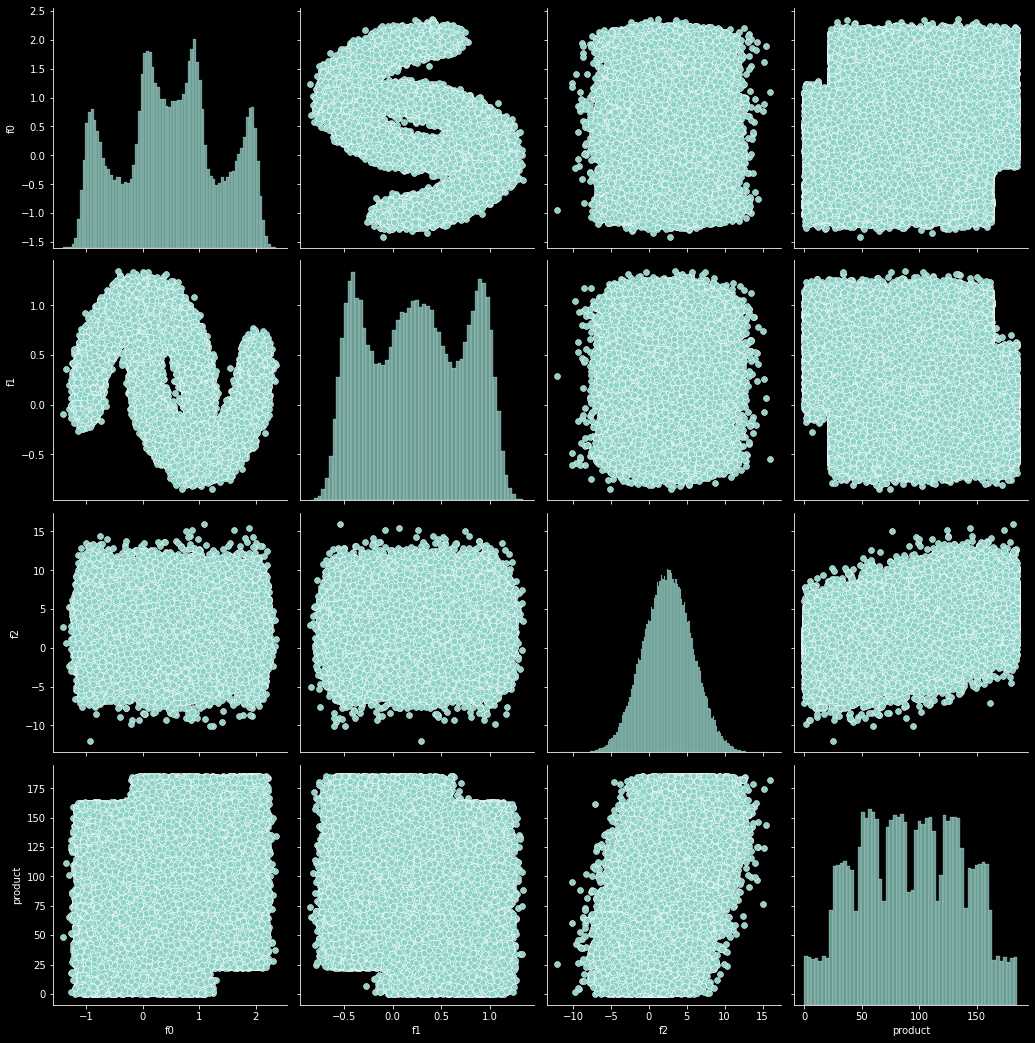

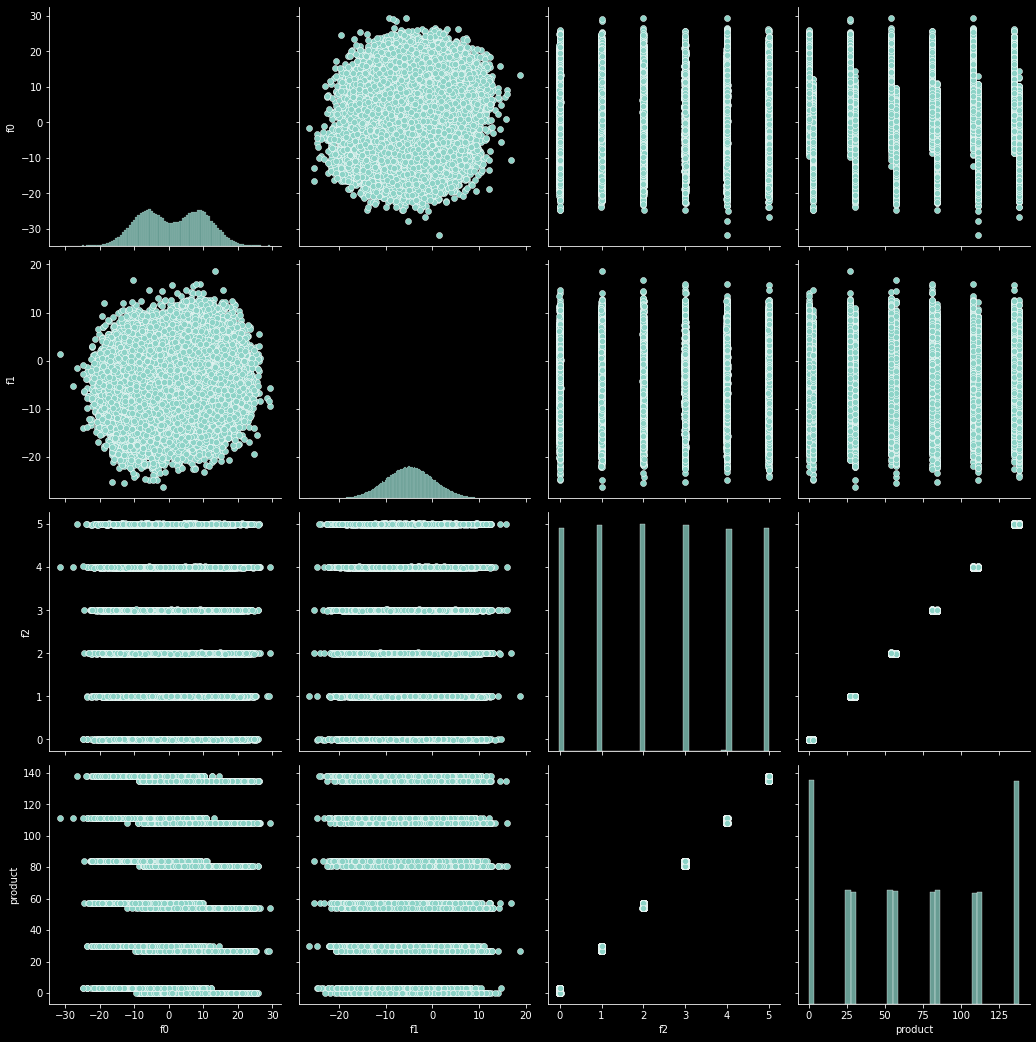

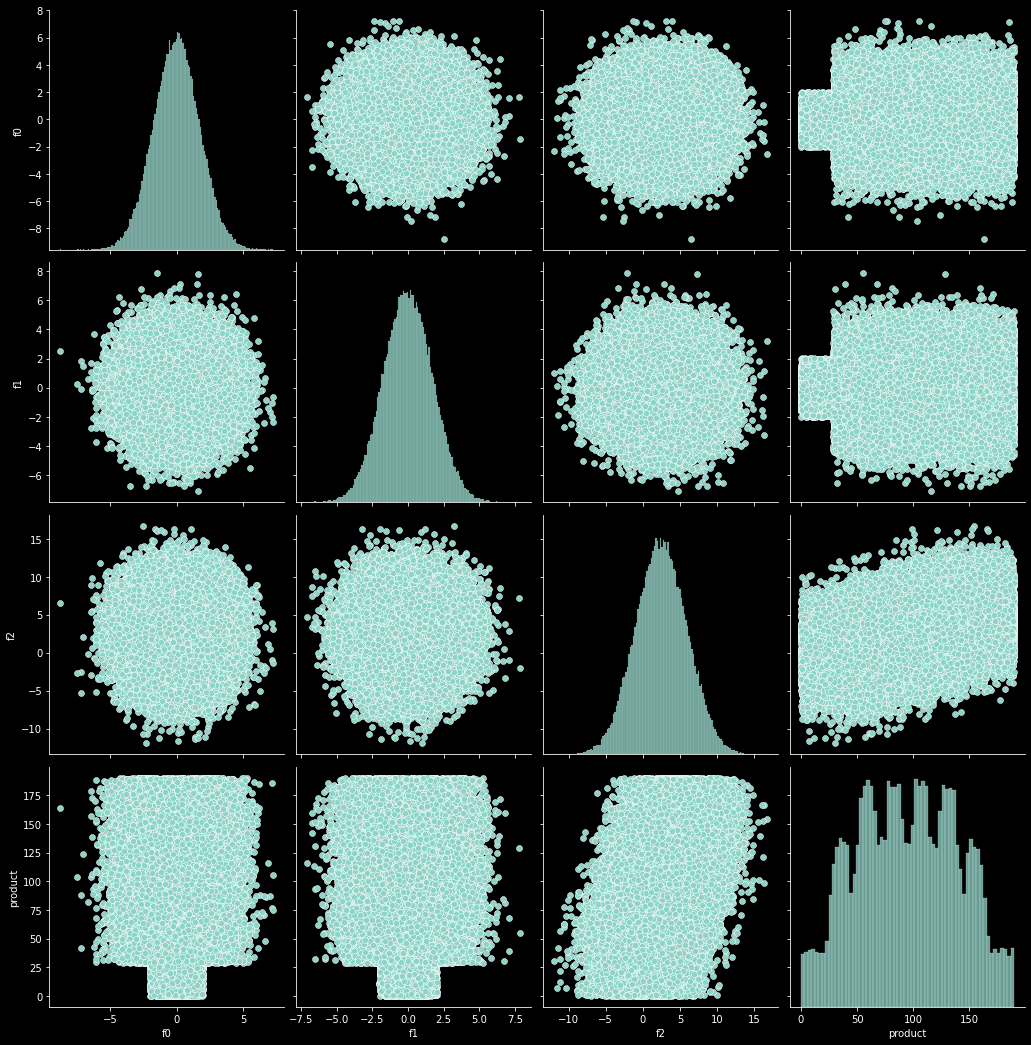

In [7]:
for datum in data: 
    plt.style.use('dark_background')
    features = datum.drop(['id'], axis=1) 
    g = sns.pairplot(features)
    g.fig.set_size_inches(15,15)

Значения в каждом датасете соответствуют своим типам, в данных нет пропусков. 

# 2 Обучите и проверьте модель для каждого региона

## 2.1  Разбейте данные на обучающую и валидационную выборки в соотношении 75:25

Функция разбиения на валидационную и тестовую выборки

In [8]:
def split(datum): 
    datum = datum.sample(frac=1, random_state=123)
    x = datum.drop(['id', 'product'], axis=1)
    y = datum['product']
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, 
                                                          train_size=0.75, 
                                                          random_state=123)
    return x_train, y_train, x_valid, y_valid

Для каждого региона сделаем разбиение на валидационную и тестовую выборки

In [9]:
x_train = []
y_train = []
x_valid = []
y_valid = []
for datum in data: 
    tup = split(datum)
    x_train.append(tup[0])
    y_train.append(tup[1])
    x_valid.append(tup[2])
    y_valid.append(tup[3])

## 2.2. Обучите модель и сделайте предсказания на валидационной выборке.

In [10]:
def prediction(x_train, y_train, x_valid, y_valid): 
    model = LinearRegression()
    scaler = StandardScaler()
    
    scaler.fit(x_train)
    x_scaled_train = scaler.transform(x_train)
    x_scaled_valid = scaler.transform(x_valid)
    
    model.fit(x_scaled_train, y_train)
    y_pred = model.predict(x_scaled_valid)
    
    RMSE = mean_squared_error(y_valid, y_pred) ** 0.5
    R2 = r2_score(y_valid, y_pred)
    
    mean_valid = y_valid.mean()
    mean_pred = y_pred.mean()
    return y_pred, RMSE, R2, mean_valid, mean_pred, model

## 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
## 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

Список 'results' будет содержать вывод функции prediction для каждого региона

В список 'models' сохраним обученные модели для каждого региона

In [11]:
results = []
models = []
for i in range(len(data)):
    res = prediction(x_train[i], y_train[i], x_valid[i], y_valid[i])
    results.append(res)
    models.append(results[-1])
    print('_'*50)
    print('Region', i+1)
    print('** RMSE:', results[i][1].round(3))
    print('R2:', results[i][2].round(5))
    print('mean_valid:', round(results[i][3], 3))
    print('** mean_predict:', round(results[i][4], 3))
    print('_'*50)

__________________________________________________
Region 1
** RMSE: 37.699
R2: 0.2746
mean_valid: 92.604
** mean_predict: 92.491
__________________________________________________
__________________________________________________
Region 2
** RMSE: 0.893
R2: 0.99962
mean_valid: 68.182
** mean_predict: 68.178
__________________________________________________
__________________________________________________
Region 3
** RMSE: 39.837
R2: 0.20343
mean_valid: 94.882
** mean_predict: 95.077
__________________________________________________


In [12]:
# print(pd.Series(results[0][0]), y_valid[0], sep=' ')
valid = y_valid[0]
x = pd.Series(results[0][0])
rows = x.sort_values(ascending=False).head(200).index
valid.iloc[rows]
# select = valid.loc[valid.index == rows, :]

51140    182.079984
93073    162.810993
78948    162.153488
22500    155.212534
75469    145.106893
            ...    
50461    127.079241
37830     98.488984
56211    143.668890
20952    154.260250
66563    130.295604
Name: product, Length: 200, dtype: float64

## 2.5. Проанализируйте результаты.

Графики (y_pred, y_valid)

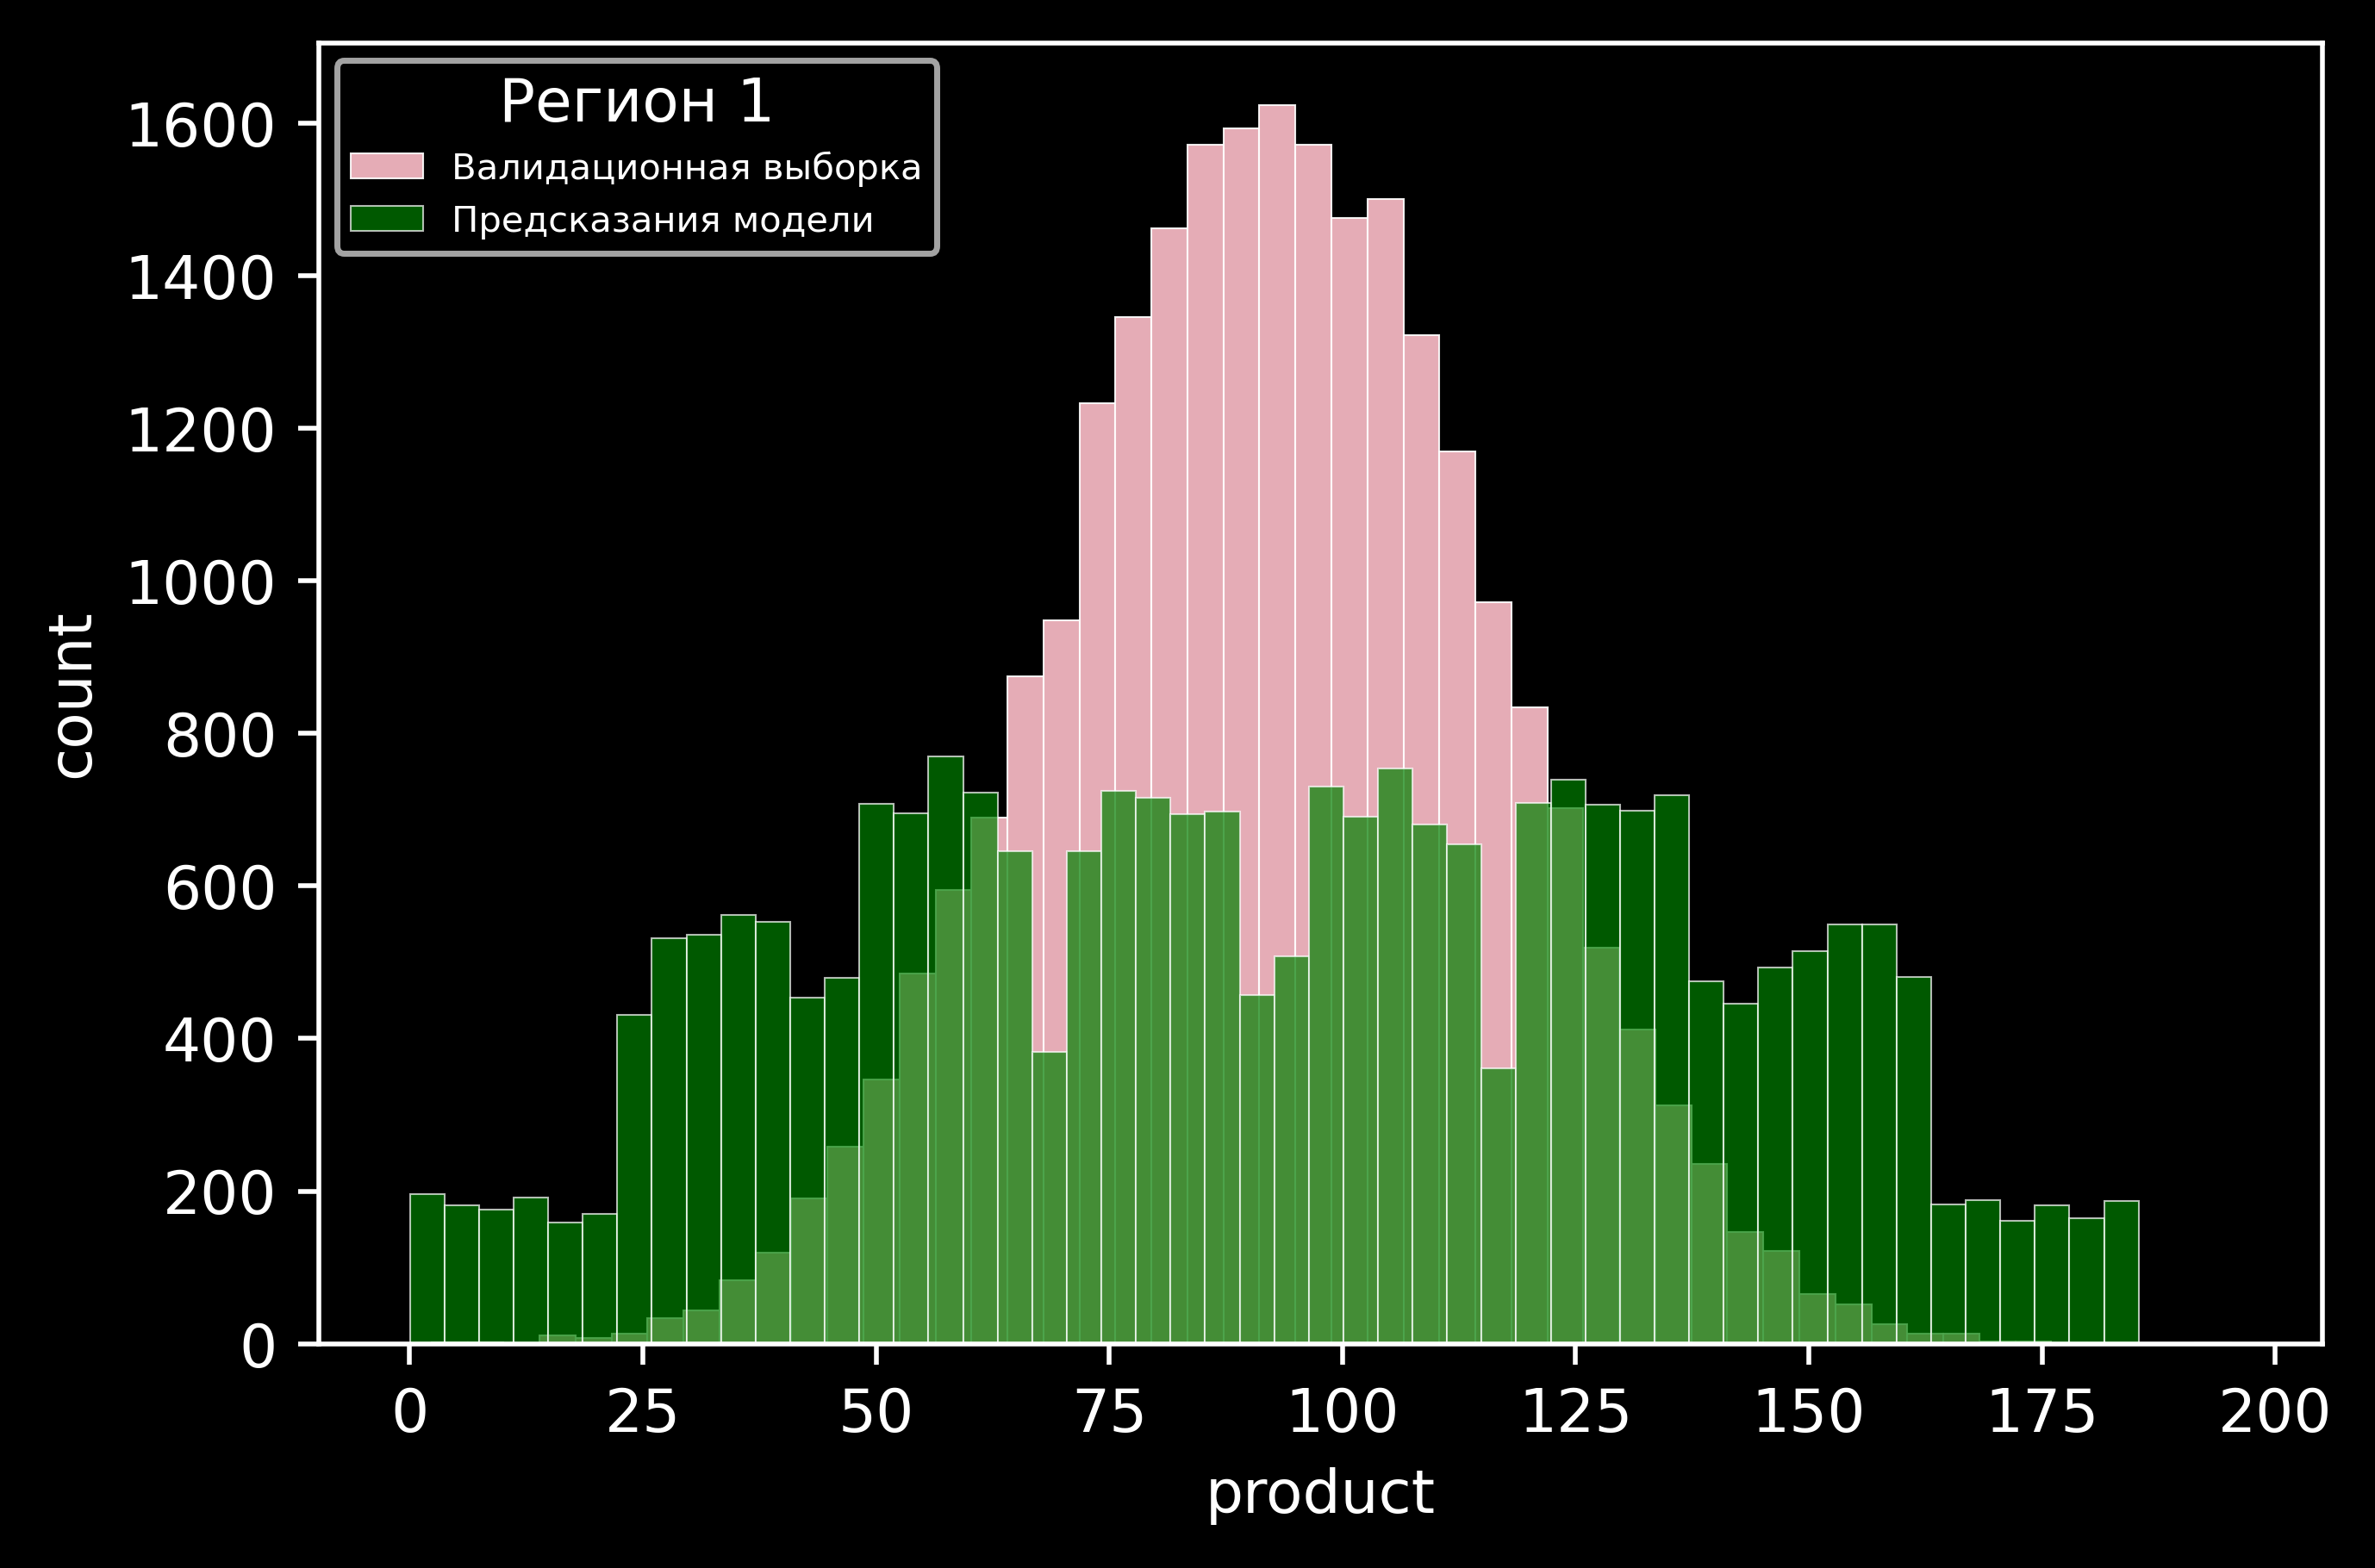

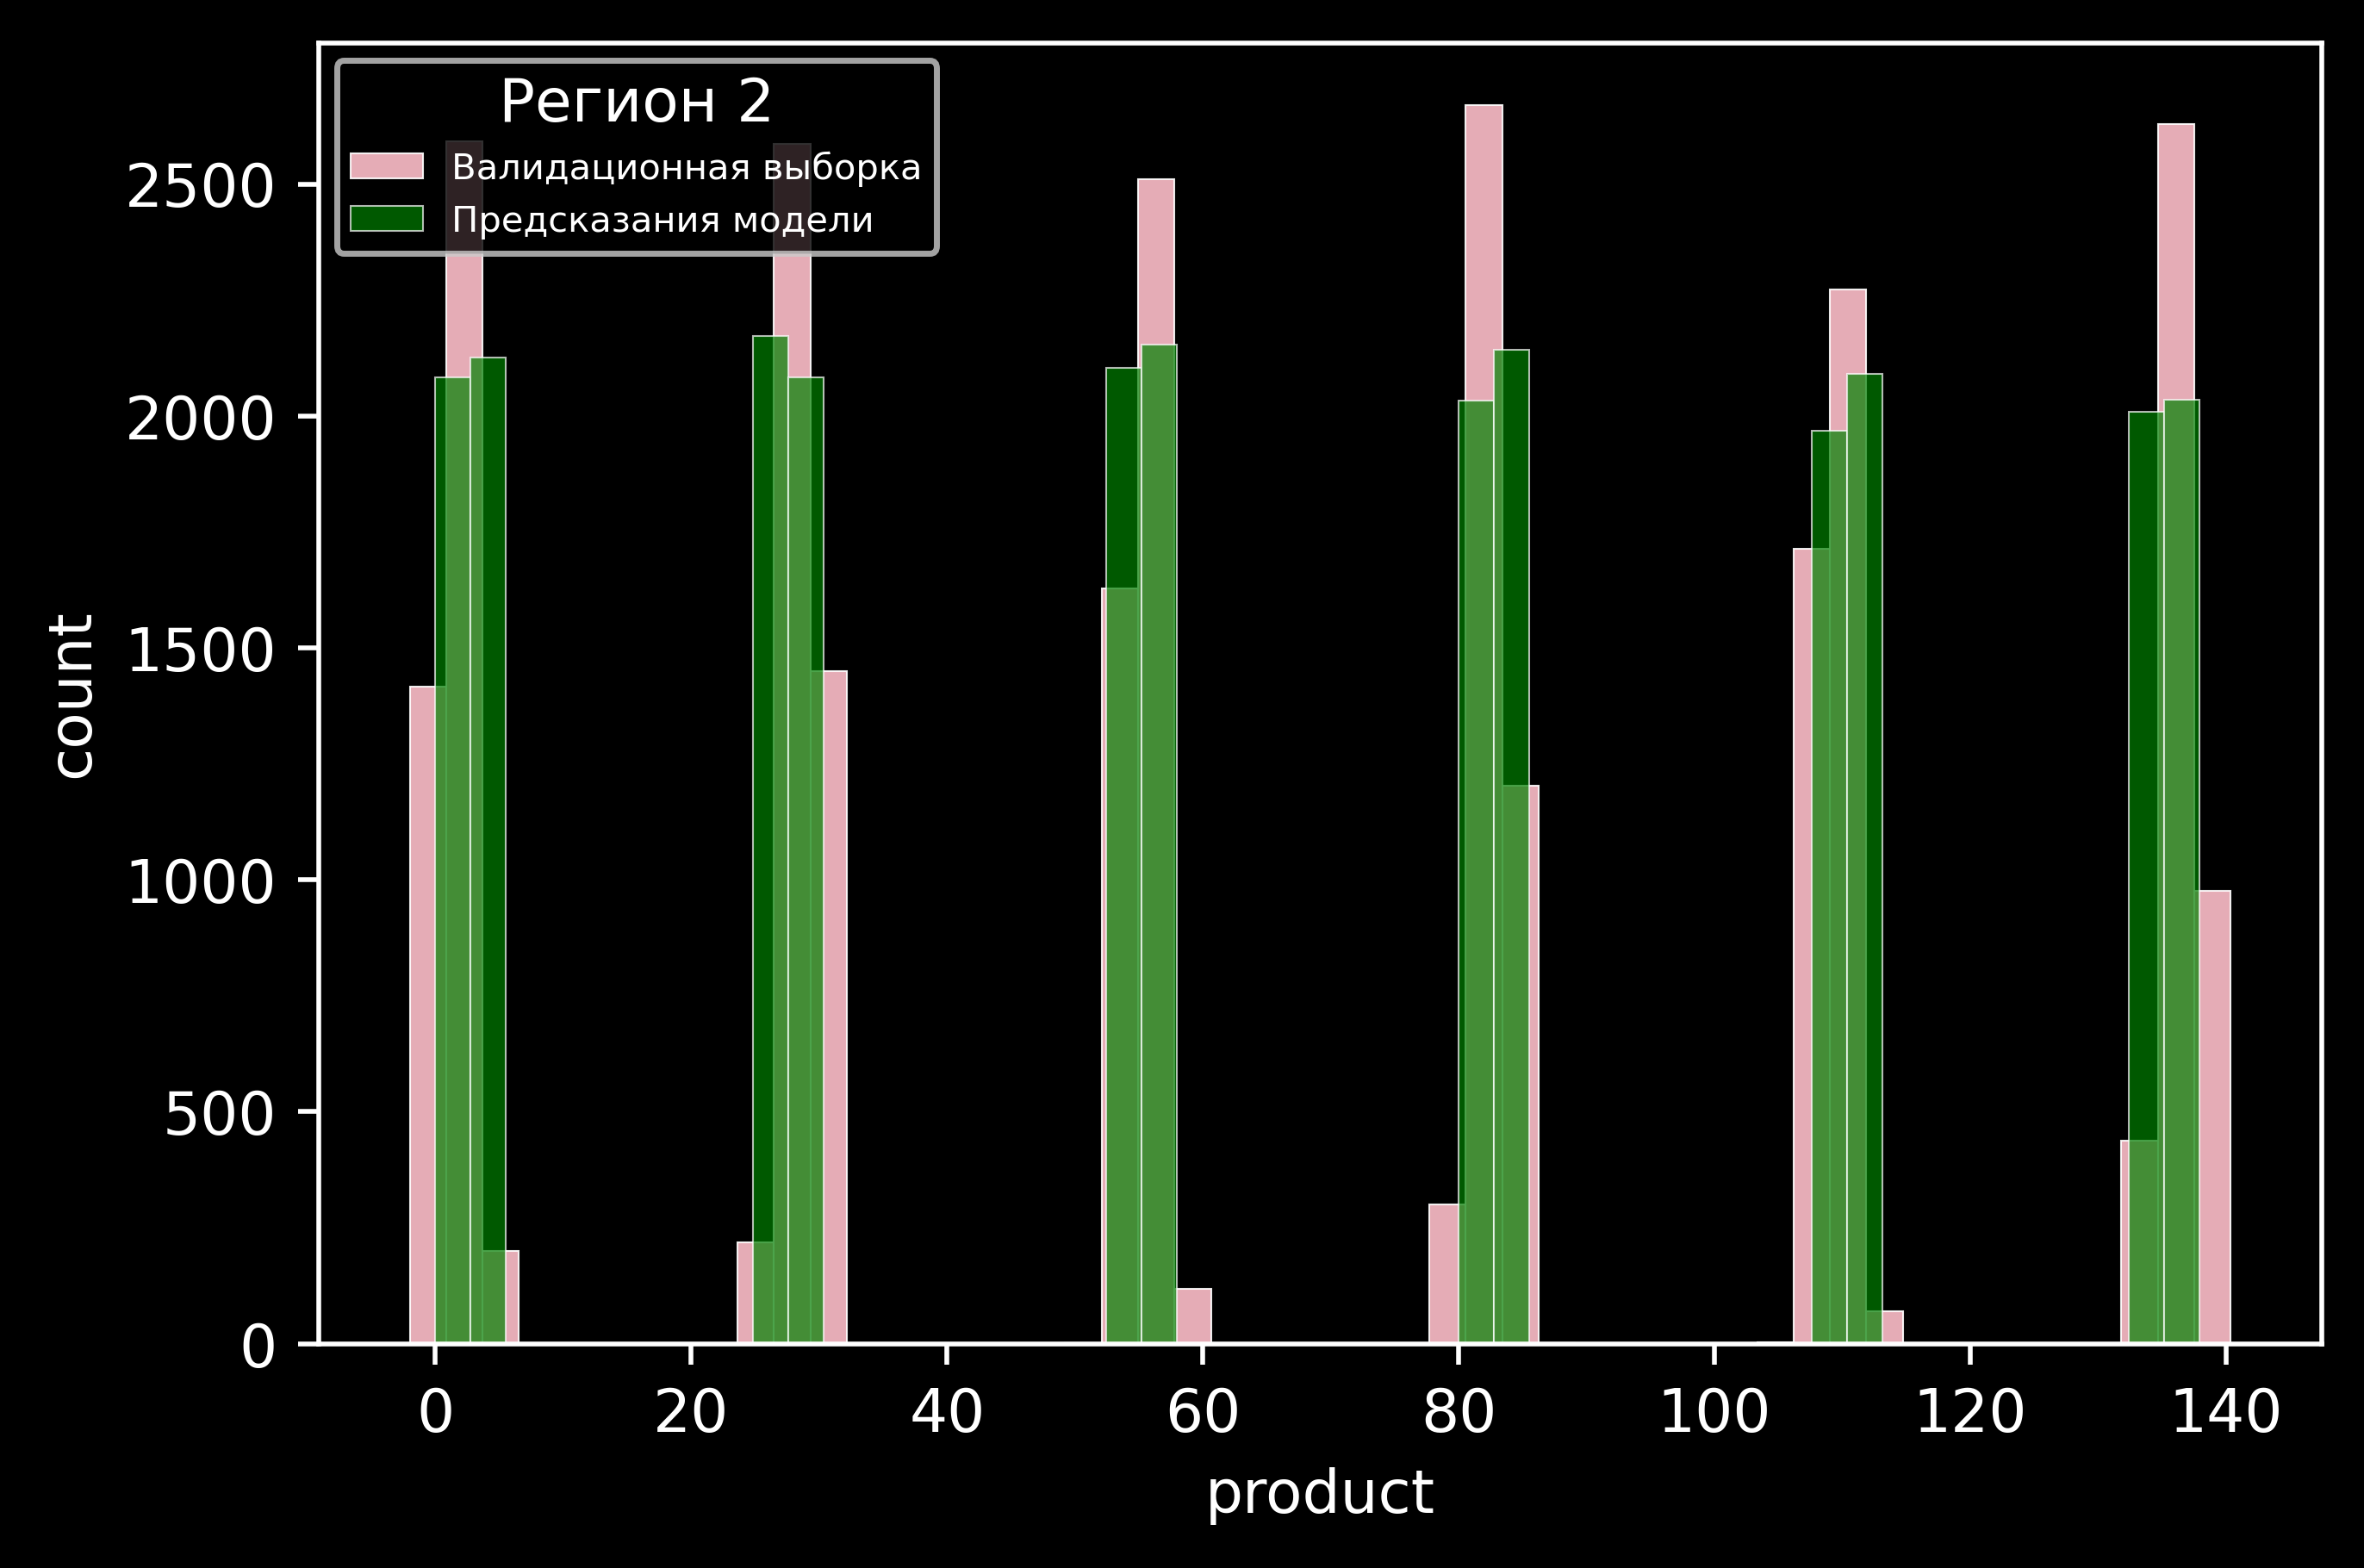

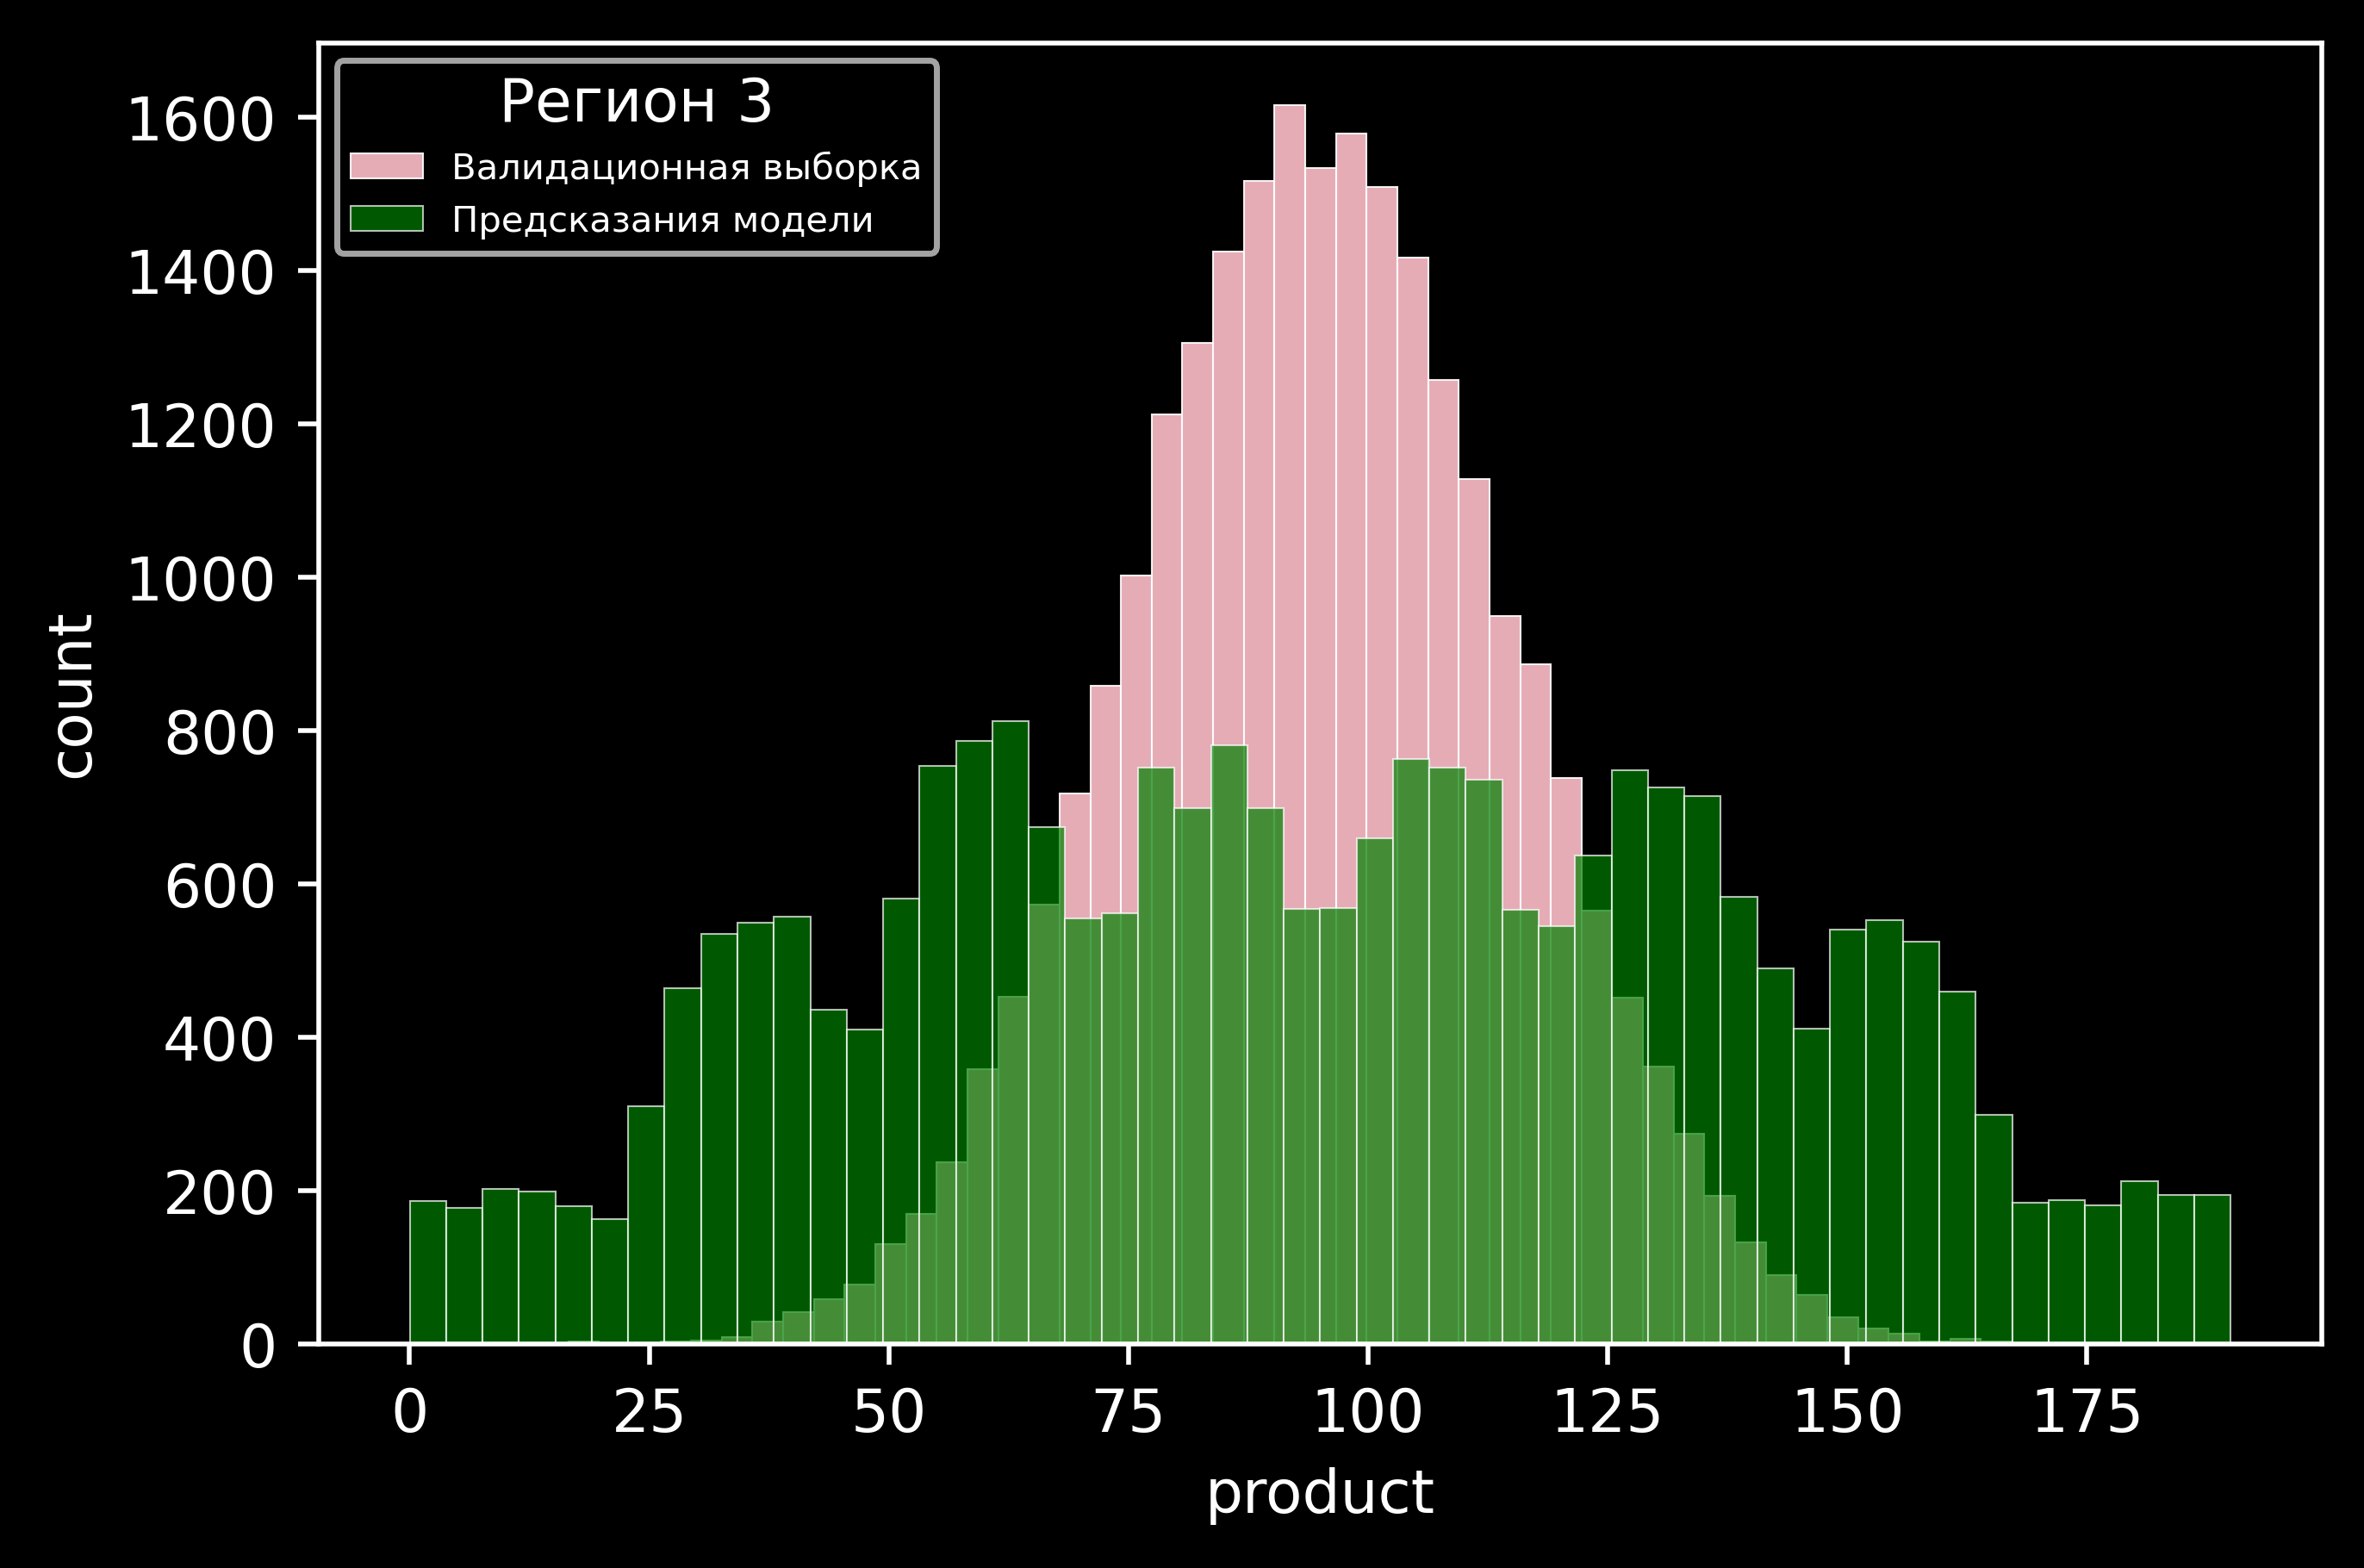

In [13]:
# сначала 1 регион 
for i in range(len(data)):
    plt.style.use('dark_background')
    ax = plt.figure(dpi=500)
    
    plt.xlabel('product')
    plt.ylabel('count')
    y_pr = results[i][0]
    y_val = y_valid[i]
    plt.hist(y_pr, bins=50, alpha = 0.9, color='pink', linewidth=0.3, ec='w');
    plt.hist(y_val, bins=50, alpha = 0.7, color='green', linewidth=0.3, ec='w');
    plt.legend(['Валидационная выборка', 'Предсказания модели'], title=f'Регион {i+1}', 
               loc='upper left', fontsize=6)
    plt.show()
    



Можем видеть, что наиболее точно модель линейной регрессии предсказывает для 2 региона, в нем распределение объема имеет изолированные пики. Для 1 и 3 регионов распределения объема имеют вид стандартного распределения, дисперсия предсказаний модели превышает дисперсию валидационной выборки. 

## 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

In [14]:
# При разведке региона исследуют 500 точек, 
# из которых с помощью машинного обучения выбирают 200 лучших для разработки.
select_points = 500 
ml_points = 200

# Бюджет на разработку скважин в регионе — 10 млрд рублей.
amount = 10e9

# Доход с каждой единицы продукта составляет 450 тыс. рублей
profit = 450e3

# После оценки рисков нужно оставить лишь те регионы, 
# в которых вероятность убытков меньше 2.5%.
prob = 0.025 



## 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

In [15]:
amount_for_one = amount / ml_points 
value = round(amount_for_one / profit, 2)
value

111.11

In [16]:
for i, datum in enumerate(data): 
    mean = round(datum['product'].mean(), 2)
    print('_'*20)
    print(f'region {i + 1}')
    if mean > value: 
        print(mean, '>', value)
    else: 
        print(mean, '<', value)
    print('_'*20)

____________________
region 1
92.5 < 111.11
____________________
____________________
region 2
68.83 < 111.11
____________________
____________________
region 3
95.0 < 111.11
____________________


# 3.3. Напишите выводы по этапу подготовки расчёта прибыли.

Можем видеть, что средние значения объема сырья в каждом регионе меньше нужного. Это случилось из-за того, что в расчет брались скважины с очень низким объемом сырья.

## 4 Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    4.1. Выберите скважины с максимальными значениями предсказаний.
    4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    4.3. Рассчитайте прибыль для полученного объёма сырья.

Функция принимает предсказания, сортирует их по убыванию, выбирает 'ml_points' первых точек, затем находит суммарную прибыль.

In [17]:
def predict_profit(y_pred, y_valid):
    top_rows = y_pred.sort_values(ascending=False).head(ml_points).index
    y_select = y_valid.iloc[top_rows]
    sum_profit = y_select.sum() * profit
    return sum_profit

## 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
## 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
## 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.


In [18]:
count = 1000
prof_lst = []
interval = []
for i in range(len(data)):
    prof_lst.append([])
    bad_count = 0
    y_pred = pd.Series(results[i][0])
    state = RandomState(123)
    
    for j in range(count):
        predictions = y_pred.sample(n=select_points, random_state=state, replace=True)
        profit_pred = predict_profit(predictions, y_valid[i])
        prof_lst[i].append(profit_pred - amount)
        if profit_pred < amount: 
            bad_count += 1 
            
    prof_lst[i] = pd.Series(prof_lst[i])   
#     interval[i].append(1)
    interval.append((prof_lst[i].quantile(prob), prof_lst[i].quantile(1-prob)))
    print('_'*55)
    print(f'Region {i+1}')
    print('risk:', round(bad_count / count * 100, 3), '%')
    print('mean:', round(prof_lst[i].mean() / 1e6, 2), 'млн.')
    print(f'confidence interval: [{round(interval[i][0] / 1e6, 2)} млн., {round(interval[i][1] / 1e6, 2)} млн.]')
    print('_'*55)
#     plt.hist(prof_lst[1], bins=50);
        
    

_______________________________________________________
Region 1
risk: 4.5 %
mean: 432.49 млн.
confidence interval: [-86.3 млн., 932.05 млн.]
_______________________________________________________
_______________________________________________________
Region 2
risk: 2.5 %
mean: 393.54 млн.
confidence interval: [6.58 млн., 779.69 млн.]
_______________________________________________________
_______________________________________________________
Region 3
risk: 9.5 %
mean: 339.22 млн.
confidence interval: [-164.17 млн., 849.69 млн.]
_______________________________________________________


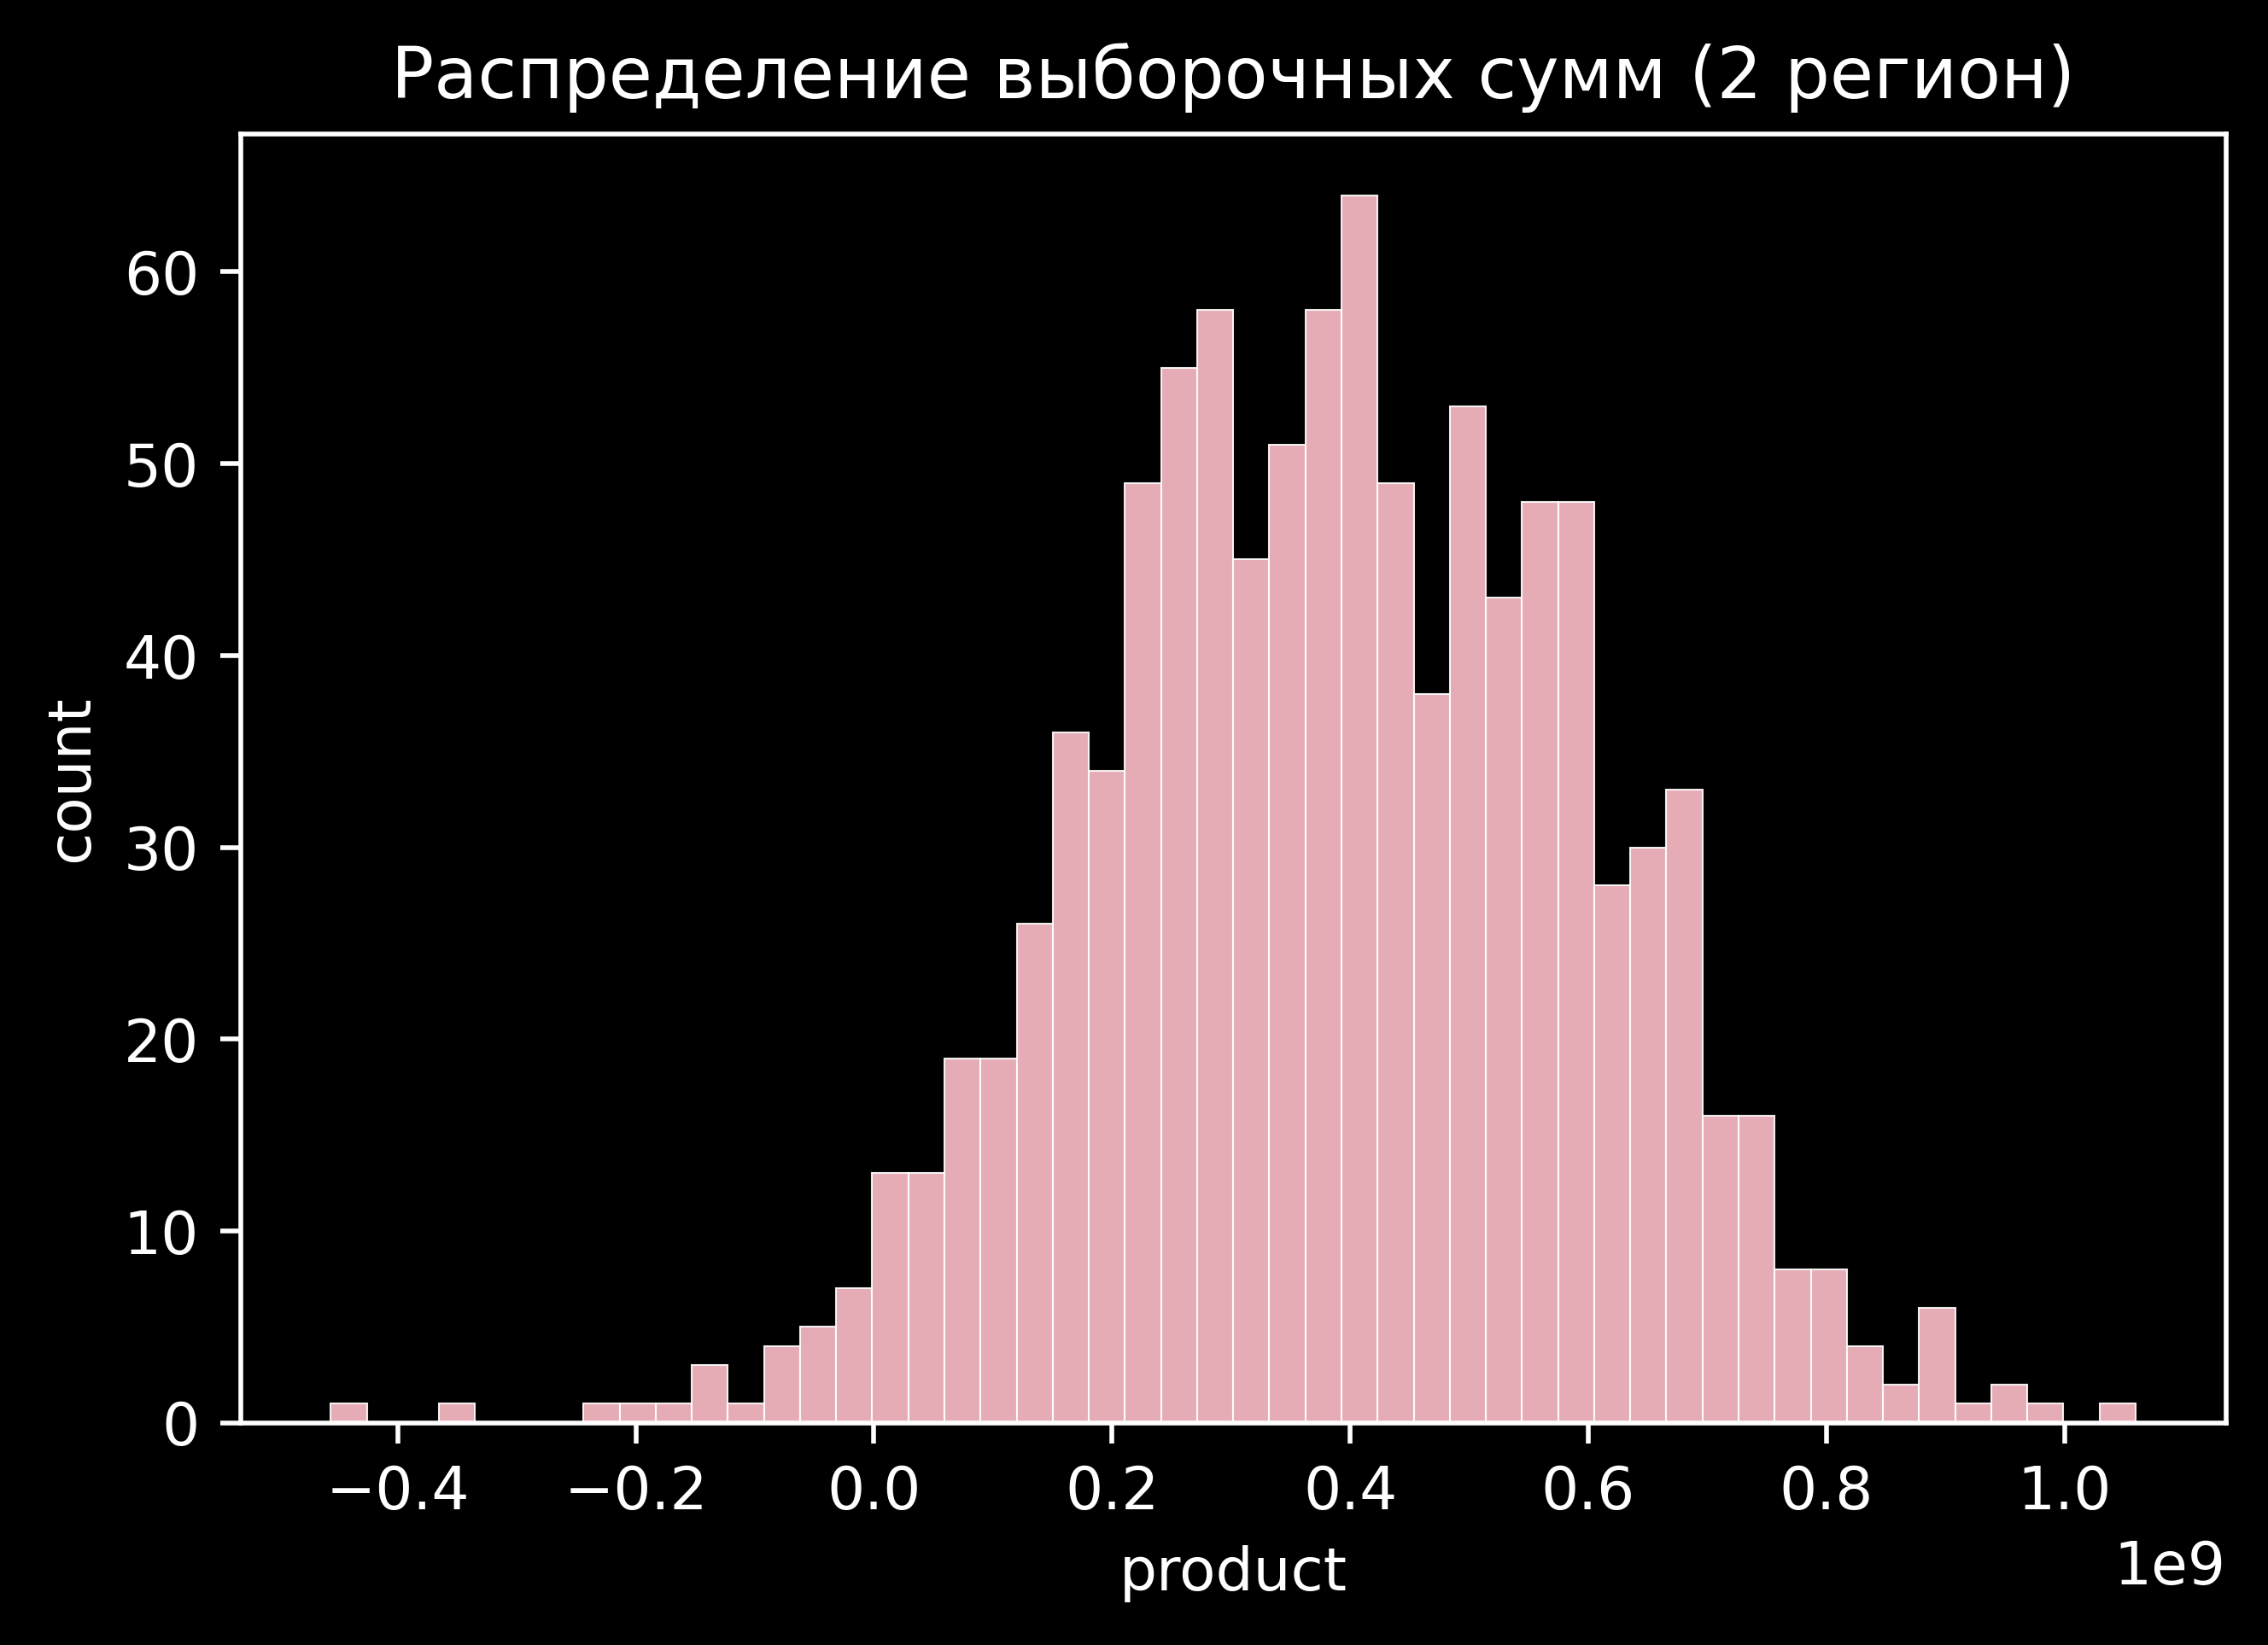

In [19]:
confid = prof_lst[1].loc[(prof_lst[1] > interval[1][0]) & (prof_lst[1] < interval[1][1])]
plt.figure(dpi=500)

plt.style.use('dark_background')
plt.hist(prof_lst[1], bins=50, alpha = 0.9, color='pink', linewidth=0.3, ec='w');
plt.xlabel('product')
plt.ylabel('count');
plt.title('Распределение выборочных сумм (2 регион)');

Для выбора оптимального региона использовался метод бутстрепа: 1000 раз выбирались 500 значений из валидационной выборки, из этих значений выбирались 200 лучших значений по предсказанию модели. Второй регион показал наиболее низкую вероятность убыточного производства, 95% доверительный интервал для него оказался равен [6.58 млн., 779.69 млн.]

# Вывод

В проекте рассматривались 3 региона, из которых нужно было выбрать наиболее перспективный для строительства скважин. Признаки были приведены к стандартному виду. Для каждого региона была обучена модель линейной регрессии. 


* Модели для 1 и 3 регионов показали невысокую точность (r2_score = 0.27 и 0.20 соответственно). В ходе анализа графиков для валидационнной выборки и предсказаний моделей выяснилось, что модели для 1 и 3 регионов делают предсказания с большей дисперсией, чем у валидационной выборки. 


* Во втором регионе модель предсказа наиболее близкие значения целевого признака. 


* С помощью метода бутстреп был выявлен второй регион с минимальным риском убытков 2.5%, среднее значение прибыли: 393.54 млн.
95% симметричный доверительный интервал: [6.58 млн., 779.69 млн.]. Этот регион следует брать для строительства скважин.